In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import math
import datetime

In [ ]:
from WindPy import w
w.start()

In [ ]:
# datelist=w.tdays(begindate, enddate, "").Data[0]

In [2]:
begindate='2010-01-01'
enddate='2021-07-28'
error_code, etf50 = w.wsd("510050.OF", "close, pre_close", begindate, enddate, "",usedf=True)
etf50.columns = etf50.columns.str.lower()

In [3]:
# continuously compounded return = dlnS = ln(close/previous close)
etf50['log_ret'] = np.log(etf50.close/etf50.pre_close)
# etf50['log_ret1'] = np.log(etf50.close/etf50.close.shift(1))
etf50['ret'] = etf50.close/etf50.pre_close

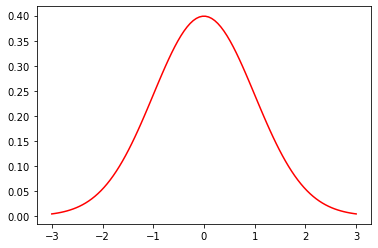

In [27]:
mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red')
plt.show()

In [32]:
stats.lognorm.pdf(0, 1)

0.0

In [30]:
lognorm_pdf(1,0,1)

0.3989422804014327

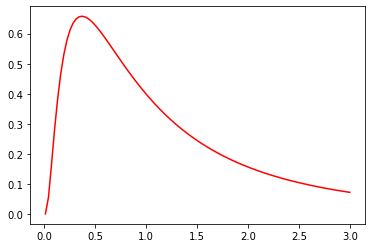

In [33]:
mu = 0 # mu is set at 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(0.01, mu + 3*sigma, 100)
plt.plot(x, stats.lognorm.pdf(x, sigma), color='red')
plt.show()

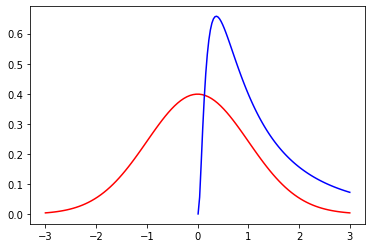

In [63]:
def norm_pdf(x,mu,sigma):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))

def lognorm_pdf(x,mu,sigma):
    return 1/(x*sigma*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-mu)**2/(2*sigma**2))

mu = 0
variance = 1
sigma = np.sqrt(variance)

x1 = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x1, norm_pdf(x1,mu,sigma), color='red')

x2 = np.linspace(0.01, mu + 3*sigma, 100)
plt.plot(x2, lognorm_pdf(x2,0,1), color='blue')

plt.show()

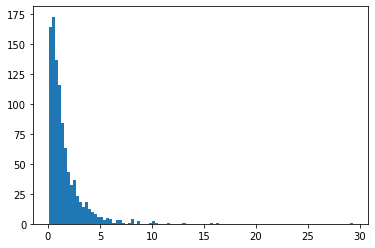

In [127]:
# 对服从正态分布的X取指数，则exp(X)其服从对数分布
a = np.random.normal(0,1,1000)
a = np.exp(a)
_ = plt.hist(a, bins=100)  # arguments are passed to np.histogram

plt.show()

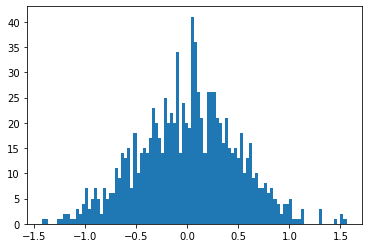

In [126]:
# 对服从对数正态分布X取对数，则log(X)服从正态分布
a = np.random.lognormal(0,0.5,1000)
a = np.log(a)
_ = plt.hist(a, bins=100)
plt.show()

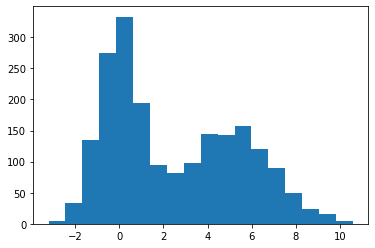

In [79]:
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

plt.show()

In [77]:
np.hist(np.random.normal(0,1,100),10)

AttributeError: module 'numpy' has no attribute 'hist'

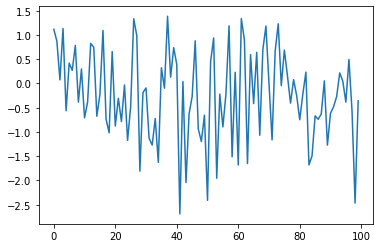

In [74]:
np.random.normal(0,1,100)

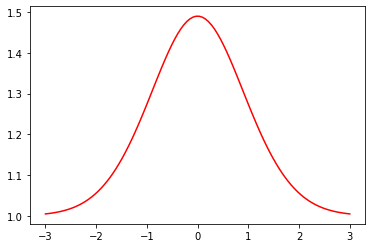

In [65]:
x1 = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x1, norm_pdf(x1,mu,sigma), color='red')

plt.show()

In [ ]:
mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)


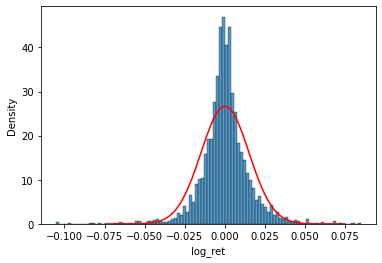

In [55]:
# 对数收益率为正态分布??????????????
sns.histplot(etf50['log_ret'],stat='density')
mu = etf50.log_ret.mean()
variance = etf50.log_ret.std()**2
sigma = np.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red')

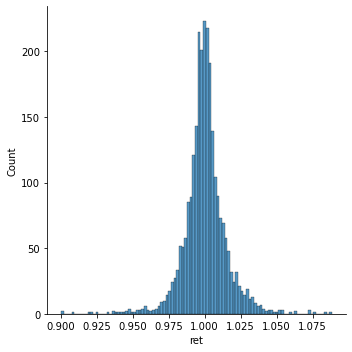

In [6]:
# 收益率为对数正态分布？？？？
sns.displot(etf50.ret)

In [ ]:
etf50['volatility_yearly'] = etf50['log_ret'].rolling(window=252).std()*np.sqrt(252)
etf50['volatility_monthly'] = etf50['log_ret'].rolling(window=21).std()*np.sqrt(252)

In [ ]:
etf50[['close','volatility_monthly','volatility_yearly']].plot(subplots=True, color='blue',figsize=(8, 6))

In [ ]:
etf50

## Geometric brownian motion

\begin{align}
    \ln S(t +\Delta t) - \ln S(t) = \left( r - \frac{\sigma^2}{2} \right) + \sigma \varepsilon \sqrt{\Delta t} \\
    S(t + \Delta t) = S(t)\exp\left[(r - \frac{\sigma^2}{2})\Delta t + \sigma \varepsilon \sqrt{\Delta t} \right]
\end{align}

In [69]:
# 每一步，即每个\Delta t 都应该抽取一个随机数，都是独立的exp部分抽取随机数，并且累乘

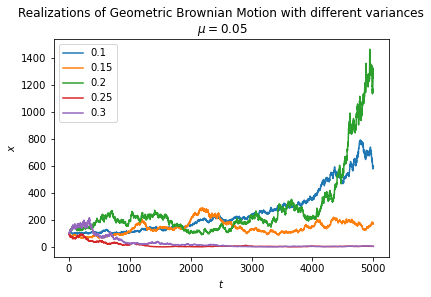

In [154]:
# monte carlo simulation
# https://en.wikipedia.org/wiki/Geometric_Brownian_motion

mu = 0.05
n = 5000
dt = 0.01
x0 = 100
np.random.seed(1)

sigma = np.arange(0.1, 0.35, 0.05) # different sigma

# calculate exponential part
x = np.exp((mu - sigma ** 2 / 2) * dt 
           + sigma * np.random.normal(0, 1, size=(n, len(sigma))) * np.sqrt(dt))
x = np.vstack([np.ones(len(sigma)), x])
# !!!scale by initial value, and cumulative product along with axis 0 (row)!!!
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    'Realizations of Geometric Brownian Motion with different variances\n $\mu={}$'.format(mu)
)
plt.show()

## BSM & Black

In [6]:
# bls model
def bls_price(S,K,r,T,sigma,cp_flag):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == 'C':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif cp_flag == 'P':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
def bls_vega(S,K,r,T,sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

def bls_impv(S,K,r,T,value,cp_flag):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        # every iter calculate a new pair of price and vega
        price = bls_price(S,K,r,T,sigma,cp_flag)
        vega = bls_vega(S,K,r,T,sigma)
        diff = price - value
        if (abs(diff) < PRECISION):
            return sigma
        # divide by zero error
        elif vega != 0:
            sigma = sigma - diff/vega
        elif vega == 0:
            return -1

In [11]:
bls_price(49,50,0.05,0.3846,0.2,'C')

2.4004610869656666

In [17]:
# c - p = S - k * exp(-rT)
S = 49
K = 50
r = 0.05
T = 0.3846
sigma = 0.2

print('{:.4f}'.format(bls_price(S,K,r,T,sigma,'C') - bls_price(S,K,r,T,sigma,'P')))

-0.0477


In [18]:
print('{:.4f}'.format(S - K*np.exp(-r*T)))

-0.0477


In [7]:
# black model
def black_price(F,K,r,T,sigma,cp_flag):
    d1 = (np.log(F / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(F / K) - (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if cp_flag == 'C':
        return np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif cp_flag == 'P':
        return np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    
def black_vega(F,K,r,T,sigma):
    d1 = (np.log(F / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = F * norm.pdf(d1) * np.sqrt(T)
    return vega

# old version, will encounter devide by zero error
def black_impv_0(F,K,r,T,value,cp_flag):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        # every iter calculate a new pair of price and vega
        price = black_price(F,K,r,T,sigma,cp_flag)
        vega = black_vega(F,K,r,T,sigma)
        diff = price - value
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma - diff/vega
        print(sigma)
    return sigma

def black_impv(F,K,r,T,value,cp_flag):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(MAX_ITERATIONS):
        # every iter calculate a new pair of price and vega
        price = black_price(F,K,r,T,sigma,cp_flag)
        vega = black_vega(F,K,r,T,sigma)
        diff = price - value
        if (abs(diff) < PRECISION):
            return sigma
        # divide by zero error
        elif vega != 0:
            sigma = sigma - diff/vega
        elif vega == 0:
            return -1